# Notebook to predict diseases in chest X-ray

In this notebook we show we can predict (inference) diseases from chest X-ray images. Refer to [ChestXray-Training.ipynb](./ChestXray-Training.ipynb) notebook for information on training the model.

## Import required modules

In [3]:
%pylab inline

import warnings
# Ignoring the warnings to improve readability of the notebook
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

from bigdl.dllib.nn.layer import Model
from bigdl.dllib.nn.criterion import *
from bigdl.dllib.optim.optimizer import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType, ArrayType

from bigdl.dllib.nncontext import *
from bigdl.dllib.feature.image import *
from bigdl.dllib.nnframes import *
from bigdl.dllib.net.net_load import Net
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.metrics import AUC
from bigdl.dllib.nnframes import NNEstimator
from bigdl.dllib.keras.objectives import BinaryCrossEntropy

import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Get Spark Content and load the trained model

In [4]:
# Function to get the Spark content and load the image
def load_spark_model(model_path, bin_path):
    # Get Spark Content
    sparkConf = create_spark_conf().setAppName("ChestXray_Inference")
    sc = init_nncontext(sparkConf)
    spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
    sqlContext = SQLContext(sc)

    # Load the model
    trained_model = Net.load(model_path, bin_path)
    return trained_model

In [5]:
# Function to display the Xray in 
def display_xray(image_path):
    img=mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()

In [29]:
def text_to_label(text):
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
               "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    label_map = {k: v for v, k in enumerate(label_texts)}

    arr = [0.0] * len(label_texts)
    for l in text.split("|"):
        if l != "No Finding":
            arr[label_map[l]] = 1.0
    return arr

def predict(model, label_path, image_path):
    
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
               "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]

    label_map = {k: v for v, k in enumerate(label_texts)}

    label_length = len(label_texts)
    
    # load the image
    getLabel = udf(lambda x: text_to_label(x), ArrayType(DoubleType()))
    getName = udf(lambda row: os.path.basename(row[0]), StringType())
    
    #NNImageReader : output DataFrame contains a single column named image
    #
    imageDF = NNImageReader.readImages(image_path, sc, resizeH=256, resizeW=256, image_codec=1)\
                    .withColumn("Image_Index", getName(col('image')))
    
    labelDF = spark.read.option('timestampFormat', 'yyyy/MM/dd HH:mm:ss ZZ')\
                .load(label_path, format="csv", sep=",", inferSchema="true", header="true")\
                .select("Image_Index", "Finding_Labels")\
                .withColumn("label", getLabel(col('Finding_Labels')))

    inferDF = imageDF.join(labelDF, on="Image_Index", how="inner")    
    
    # Predict output of when inputdf is passed through model
    transformer = ChainedPreprocessing([
        RowToImageFeature(),
        ImageCenterCrop(224, 224),
        ImageChannelNormalize(123.68, 116.779, 103.939),
        ImageMatToTensor(),
        ImageFeatureToTensor()])
    classifier_model = NNModel(model, transformer).setFeaturesCol("image")\
                        .setBatchSize(1)
    output = classifier_model.transform(inferDF)
    return output

def print_prediction_output(predDF):
    print("\n\n")  
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
               "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]

    predictions_list = predDF.collect()[0].prediction
    labelList = predDF.collect()[0].label
    print("{:<25} - {:<25} - {:<15}".format('Finding_Labels', 'Prediction', 'Label'))
    print("{:<25} - {:<25} - {:<15}".format('-'*len('Finding_Labels'), '-'*len('Prediction'), '-'*len('Label')))
    for indx in range(0, len(predictions_list)):
        print("{:<25} - {:<25} - {:<15}".format(label_texts[indx], predictions_list[indx], labelList[indx]))
    print("\n\n")

In [30]:
%%time
if __name__== "__main__":
    
    # Path to the NIH label file, the model and the labels from NIH
    model_path = "/opt/application/data/model" + "/xray_model_classif.bigdl"
    bin_path = "/opt/application/data/model" + "/xray_model_classif.bin"
    label_path = "/opt/application/data" + "/Data_Entry_2017_v2020.csv"
   
    trained_model = load_spark_model(model_path,bin_path)

2022-04-06 13:01:01,983 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:01,984 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:01,984 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:01,984 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-04-06 13:01:01 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-04-06 13:01:01 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 6
22-04-06 13:01:01 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 15
2022-04-06 13:01:01 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
22-04-06 13:01:01 [Thread-4] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...
CPU times: user 19.9 ms, sys: 10 ms, total: 29.9 ms
Wall time: 423 ms


In [31]:
# Get Spark Context
sparkConf = create_spark_conf().setAppName("Chest X-ray Training")
sc = init_nncontext(sparkConf)
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()

2022-04-06 13:01:02,764 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:02,764 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:02,765 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-04-06 13:01:02,765 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-04-06 13:01:02 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-04-06 13:01:02 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 6
22-04-06 13:01:02 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 15
2022-04-06 13:01:02 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
22-04-06 13:01:02 [Thread-4] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...


In [35]:
%%time
    # Path to the image for inference
    image_path = "gs:///opt/application/data/output" + "/00000001_002.png"
    predictionDF = predict(trained_model, label_path, image_path)
    print_prediction_output(predictionDF)

KeyboardInterrupt: 

2022-04-06 13:24:16 WARN  FileSystem:3473 - Failed to initialize fileystem gs:///opt/application/data/output/00000001_002.png: java.io.IOException: Error getting access token from metadata server at: http://169.254.169.254/computeMetadata/v1/instance/service-accounts/default/token


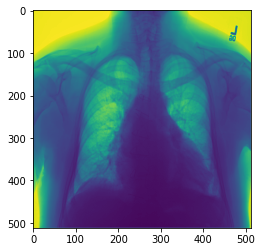

In [33]:
display_xray(image_path)